<a href="https://www.kaggle.com/code/arfanmd/lipreading?scriptVersionId=125089096" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Installing and importing modules

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
!pip install -U --no-cache-dir gdown --pre

In [3]:
import os
import cv2 # preprocessing data
import tensorflow as tf # training model
import numpy as np # data manipulation
from typing import List
from matplotlib import pyplot as plt # post processing ploting
import imageio # numpy => GIF

In [4]:
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [5]:
# limit memory to prevent data leak

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
  

2 Physical GPUs, 2 Logical GPUs


Data Loading Functions

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/u/0/uc?id=1o0RsN-LQsu703DIu0o-aw3Uh9SRpBz_6&export=download'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1o0RsN-LQsu703DIu0o-aw3Uh9SRpBz_6&export=download
From (redirected): https://drive.google.com/uc?id=1o0RsN-LQsu703DIu0o-aw3Uh9SRpBz_6&export=download&confirm=t&uuid=0f34d08b-b919-46e2-8c3a-5fae729730e9
To: /kaggle/working/data.zip
100%|██████████| 423M/423M [00:10<00:00, 40.8MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
    # selecting the lip area from the whole image statically
  cap.release()
  # standadizing the images
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames - mean),tf.float32) /std 


In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
# converting char to num inorder to tokenize the dataset
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab,
                                           oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",invert=True
)
print(f"The vocabulary is : {char_to_num.get_vocabulary()}\n"
      f"(size = {char_to_num.vocabulary_size()}")


The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
(size = 40


In [11]:
char_to_num(["a","b","d"]) # encoding it to [1,2,4]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 4])>

In [12]:
num_to_char([1,2,4]) # decoding it back to a,b,d

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'a', b'b', b'd'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str): 
  path = bytes.decode(path.numpy())
  file_name = path.split('/')[-1].split(".")[0]
  video_path = os.path.join('data','s1',f"{file_name}.mpg")
  alignment_path = os.path.join("data","alignments",'s1',f"{file_name}.align")
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)
  
  return frames,alignments

In [15]:
test_path = './data/s1/bbal6n.mpg'

In [16]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

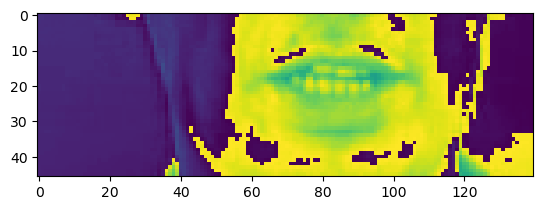

In [17]:
frame = frames[40].numpy().squeeze()
plt.imshow(frame);

In [18]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [19]:
# wrapper used for string input data pipelines
def mappable_function(path:str) -> List[str]:
  result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
  return result

Create Data Pipeline






In [20]:
from matplotlib import pyplot as plt

In [21]:
# import tensorflow as tf
# data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# data = data.shuffle(100,reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # padding alignments to 40
# data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40])) 
# data = data.prefetch(tf.data.AUTOTUNE)
# data

data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [22]:
print(f"Data size after spliting into batches : {data.cardinality().numpy()}")

Data size after spliting into batches : 500


In [23]:
len((data.as_numpy_iterator().next())[0][0][0][0][0])
# (2,75,46,140,1)

1

In [24]:
len(frames)

75

In [25]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [26]:
test = data.as_numpy_iterator()

In [27]:
val = test.next(); val[0]

array([[[[[ 1.3511412 ],
          [ 1.3125372 ],
          [ 0.84928876],
          ...,
          [ 0.3088323 ],
          [ 0.3088323 ],
          [ 0.3088323 ]],

         [[ 1.119517  ],
          [ 1.2739332 ],
          [ 0.81068474],
          ...,
          [ 0.3088323 ],
          [ 0.3088323 ],
          [ 0.3088323 ]],

         [[ 1.5827655 ],
          [ 1.5827655 ],
          [ 1.2739332 ],
          ...,
          [ 0.3088323 ],
          [ 0.27022824],
          [ 0.27022824]],

         ...,

         [[ 1.158121  ],
          [ 1.080913  ],
          [ 1.080913  ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.080913  ],
          [ 1.080913  ],
          [ 1.080913  ],
          ...,
          [ 9.844028  ],
          [ 9.844028  ],
          [ 9.844028  ]],

         [[ 1.080913  ],
          [ 1.080913  ],
          [ 1.080913  ],
          ...,
          [ 9.844028  ],
          [ 9.844028  ],
          

In [28]:
imageio.mimsave('./animation.gif',val[0][0],fps=10)

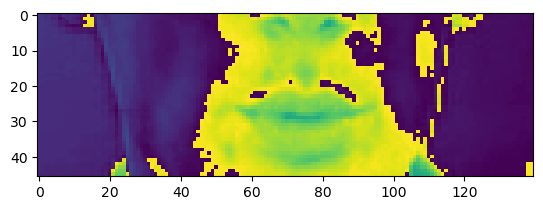

In [29]:
plt.imshow(val[0][0][35].squeeze());

In [30]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t one again'>

Design the Deep Neural Network

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [32]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [33]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same')) # padding = same means ouput shape is preserved
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(256,3,padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(75,3,padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(TimeDistributed(Flatten())) # 75 inputs and 75 outputs


    model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer="he_normal",activation='softmax'))
    

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [35]:
5*17*75

6375

In [36]:
yhat = model.predict(val[0])
# yhat = model.predict(val[0])
# prediction before training
val[0].shape

1/1 [==============================] - 10s 10s/step


(2, 75, 46, 140, 1)

In [37]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiu'>

In [38]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiu'>

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 75, 41)

Setup Training options and Train

In [41]:
# Taken from Automatic Speech recognision model
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [42]:
def scheduler(epoch,lr):
  if epoch<30:
    return lr
  else:
    return lr* tf.math.exp(-0.1)

In [43]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss) 

In [45]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [46]:
schedule_callback = LearningRateScheduler(scheduler)

In [47]:
# Added for split 

# train = data.take(450)
# test = data.skip(450)

In [48]:
print(f"batch - Training data :{train.cardinality().numpy()}")


batch - Training data :450


In [49]:
example_callback = ProduceExample(data)

In [50]:
mkdir /kaggle/working/models

In [51]:
model.fit(data, epochs=100,batch_size=16 ,callbacks=[checkpoint_callback, schedule_callback,example_callback])
# model.fit(train, validation_data=test, batch_size=16,epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
485/500 [============================>.] - ETA: 11s - loss: 83.7915

[mpeg1video @ 0x72839c060e80] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c060e80] Warning MVs not available


1/1 [==============================] - 4s 4s/step
Original: set green with p eight now
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red by j four now
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 398s 758ms/step - loss: 83.4755 - lr: 1.0000e-04
Epoch 2/100
214/500 [===========>..................] - ETA: 3:33 - loss: 71.4836

[mpeg1video @ 0x7284a881ed40] ac-tex damaged at 22 17
[mpeg1video @ 0x7284a881ed40] Warning MVs not available


1/1 [==============================] - 0s 386ms/step
Original: place blue at i four now
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in e one again
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 747ms/step - loss: 70.1838 - lr: 1.0000e-04
Epoch 3/100
 81/500 [===>..........................] - ETA: 5:13 - loss: 68.0947

[mpeg1video @ 0x728099509680] ac-tex damaged at 22 17
[mpeg1video @ 0x728099509680] Warning MVs not available


1/1 [==============================] - 0s 390ms/step
Original: bin white by n two now
Prediction: la e e t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white by f two now
Prediction: la e e t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 748ms/step - loss: 66.5704 - lr: 1.0000e-04
Epoch 4/100
188/500 [==========>...................] - ETA: 3:51 - loss: 64.1764

[mpeg1video @ 0x57e2492b7800] ac-tex damaged at 22 17
[mpeg1video @ 0x57e2492b7800] Warning MVs not available


1/1 [==============================] - 0s 386ms/step
Original: place red at c nine again
Prediction: la re t e ea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with t three again
Prediction: la re t e ea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 373s 745ms/step - loss: 63.4344 - lr: 1.0000e-04
Epoch 5/100
111/500 [=====>........................] - ETA: 4:52 - loss: 61.5873

[mpeg1video @ 0x7284b6b07540] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b6b07540] Warning MVs not available


1/1 [==============================] - 0s 384ms/step
Original: bin blue at f four please
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red in h one soon
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 375s 750ms/step - loss: 61.3994 - lr: 1.0000e-04
Epoch 6/100
147/500 [=======>......................] - ETA: 4:25 - loss: 60.2010

[mpeg1video @ 0x728082286d40] ac-tex damaged at 22 17
[mpeg1video @ 0x728082286d40] Warning MVs not available


1/1 [==============================] - 0s 381ms/step
Original: bin red at g one again
Prediction: la re t e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in d seven again
Prediction: la re t e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 754ms/step - loss: 58.6608 - lr: 1.0000e-04
Epoch 7/100
 76/500 [===>..........................] - ETA: 5:15 - loss: 56.5050

[mpeg1video @ 0x57e2487aac00] ac-tex damaged at 22 17
[mpeg1video @ 0x57e2487aac00] Warning MVs not available


1/1 [==============================] - 0s 388ms/step
Original: lay blue with r two now
Prediction: la re i e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green at s three soon
Prediction: la re i e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 372s 745ms/step - loss: 55.6157 - lr: 1.0000e-04
Epoch 8/100
329/500 [==================>...........] - ETA: 2:06 - loss: 53.9600

[mpeg1video @ 0x7284b69fd380] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b69fd380] Warning MVs not available


1/1 [==============================] - 0s 384ms/step
Original: bin red by g four please
Prediction: la re i e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red at m four please
Prediction: la re t e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 372s 744ms/step - loss: 53.8743 - lr: 1.0000e-04
Epoch 9/100
328/500 [==================>...........] - ETA: 2:08 - loss: 52.2966

[mpeg1video @ 0x7284886a6b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7284886a6b80] Warning MVs not available


1/1 [==============================] - 0s 387ms/step
Original: set white with j zero please
Prediction: la re t e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by v nine soon
Prediction: la re t ie o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 375s 751ms/step - loss: 52.1934 - lr: 1.0000e-04
Epoch 10/100
229/500 [============>.................] - ETA: 3:22 - loss: 50.5709

[mpeg1video @ 0x7283b4018d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b4018d00] Warning MVs not available


1/1 [==============================] - 0s 377ms/step
Original: lay red in y three again
Prediction: sla re i ie aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by u two please
Prediction: sla re i ie as
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 748ms/step - loss: 50.3209 - lr: 1.0000e-04
Epoch 11/100
 17/500 [>.............................] - ETA: 6:02 - loss: 49.3146

[mpeg1video @ 0x7284bfb26b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfb26b00] Warning MVs not available


1/1 [==============================] - 0s 395ms/step
Original: place green by y six please
Prediction: sla re i e lae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue in v one again
Prediction: sla re t e ae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 747ms/step - loss: 48.3267 - lr: 1.0000e-04
Epoch 12/100
273/500 [===============>..............] - ETA: 2:49 - loss: 46.6838

[mpeg1video @ 0x72849806d080] ac-tex damaged at 22 17
[mpeg1video @ 0x72849806d080] Warning MVs not available


1/1 [==============================] - 0s 380ms/step
Original: place red with d five soon
Prediction: pla re t oe on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by h three soon
Prediction: la re t on o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 752ms/step - loss: 46.3592 - lr: 1.0000e-04
Epoch 13/100
 15/500 [..............................] - ETA: 6:18 - loss: 42.8106

[mpeg1video @ 0x7283b407e2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b407e2c0] Warning MVs not available


1/1 [==============================] - 0s 371ms/step
Original: set green by j two please
Prediction: sla wre t oe lase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with a three soon
Prediction: sla re it ie on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 747ms/step - loss: 44.1921 - lr: 1.0000e-04
Epoch 14/100
214/500 [===========>..................] - ETA: 3:34 - loss: 44.8637

[mpeg1video @ 0x7284bfc47a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfc47a40] Warning MVs not available


1/1 [==============================] - 0s 381ms/step
Original: bin red sp by g two now
Prediction: plac ble i ie ow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red by m nine again
Prediction: plac ble b ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 751ms/step - loss: 43.7766 - lr: 1.0000e-04
Epoch 15/100
164/500 [========>.....................] - ETA: 4:10 - loss: 40.7320

[mpeg1video @ 0x7284ac008d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7284ac008d40] Warning MVs not available


1/1 [==============================] - 0s 316ms/step
Original: bin red by t two please
Prediction: la re t o plase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in f six please
Prediction: set re t ie plase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 747ms/step - loss: 39.9414 - lr: 1.0000e-04
Epoch 16/100
380/500 [=====================>........] - ETA: 1:29 - loss: 37.5344

[mpeg1video @ 0x7280716d9d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7280716d9d00] Warning MVs not available


1/1 [==============================] - 0s 376ms/step
Original: set white at i zero now
Prediction: set re it on now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue by z nine soon
Prediction: bln blue by eie on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 375s 750ms/step - loss: 37.3643 - lr: 1.0000e-04
Epoch 17/100
 76/500 [===>..........................] - ETA: 5:11 - loss: 34.9515

[mpeg1video @ 0x57e24a912d00] ac-tex damaged at 22 17
[mpeg1video @ 0x57e24a912d00] Warning MVs not available


1/1 [==============================] - 1s 506ms/step
Original: lay blue in j seven soon
Prediction: bla blue it se son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with g four please
Prediction: pla re it or please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 373s 745ms/step - loss: 34.9722 - lr: 1.0000e-04
Epoch 18/100
171/500 [=========>....................] - ETA: 4:04 - loss: 32.9269

[mpeg1video @ 0x7284b6c23500] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b6c23500] Warning MVs not available


1/1 [==============================] - 0s 379ms/step
Original: lay white at r eight please
Prediction: bia wre it ie please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with i zero please
Prediction: bin wre it or please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 373s 746ms/step - loss: 32.2949 - lr: 1.0000e-04
Epoch 19/100
321/500 [==================>...........] - ETA: 2:14 - loss: 29.8409

[mpeg1video @ 0x72806a7dae80] ac-tex damaged at 22 17
[mpeg1video @ 0x72806a7dae80] Warning MVs not available


1/1 [==============================] - 0s 389ms/step
Original: set green in v one soon
Prediction: set gre in oe son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red at k seven soon
Prediction: lay red an eve son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 753ms/step - loss: 29.8648 - lr: 1.0000e-04
Epoch 20/100
209/500 [===========>..................] - ETA: 3:38 - loss: 27.9149

[mpeg1video @ 0x72839c121800] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c121800] Warning MVs not available


1/1 [==============================] - 0s 378ms/step
Original: lay red in y two please
Prediction: lay red in oe please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white with u three again
Prediction: bin white wth h he again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 375s 750ms/step - loss: 27.5972 - lr: 1.0000e-04
Epoch 21/100
159/500 [========>.....................] - ETA: 4:15 - loss: 25.8257

[mpeg1video @ 0x7284b1465600] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b1465600] Warning MVs not available


1/1 [==============================] - 0s 371ms/step
Original: place white by y one again
Prediction: place white by oe ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in g eight please
Prediction: bin ren in ix please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 375s 749ms/step - loss: 25.2369 - lr: 1.0000e-04
Epoch 22/100
157/500 [========>.....................] - ETA: 4:15 - loss: 23.6730

[mpeg1video @ 0x7284886d9000] ac-tex damaged at 22 17
[mpeg1video @ 0x7284886d9000] Warning MVs not available


1/1 [==============================] - 0s 380ms/step
Original: set red with i three soon
Prediction: set red with te son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green at f five soon
Prediction: lay gren at fie son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 375s 750ms/step - loss: 23.1733 - lr: 1.0000e-04
Epoch 23/100
167/500 [=========>....................] - ETA: 4:08 - loss: 20.8267

[mpeg1video @ 0x7283b0048340] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b0048340] Warning MVs not available


1/1 [==============================] - 0s 398ms/step
Original: place blue at o eight now
Prediction: place blue at igt now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white with n seven soon
Prediction: bin white wit sie son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 751ms/step - loss: 20.7646 - lr: 1.0000e-04
Epoch 24/100
379/500 [=====================>........] - ETA: 1:30 - loss: 19.0594

[mpeg1video @ 0x7284bfb0d640] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfb0d640] Warning MVs not available


1/1 [==============================] - 0s 382ms/step
Original: set white with p three soon
Prediction: set white wth h hre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at g nine soon
Prediction: set blue an ine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 749ms/step - loss: 18.9761 - lr: 1.0000e-04
Epoch 25/100
 74/500 [===>..........................] - ETA: 5:19 - loss: 17.5786

[mpeg1video @ 0x7284a887f1c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284a887f1c0] Warning MVs not available


1/1 [==============================] - 0s 367ms/step
Original: set red in t eight now
Prediction: set gred in igt now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with k five soon
Prediction: place white with five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 373s 746ms/step - loss: 17.3959 - lr: 1.0000e-04
Epoch 26/100
451/500 [==========================>...] - ETA: 36s - loss: 16.1511

[mpeg1video @ 0x728060b94b80] ac-tex damaged at 22 17
[mpeg1video @ 0x728060b94b80] Warning MVs not available


1/1 [==============================] - 0s 371ms/step
Original: lay white in e six please
Prediction: lay white in ix please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with b five soon
Prediction: bin gren with five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 375s 749ms/step - loss: 16.0542 - lr: 1.0000e-04
Epoch 27/100
258/500 [==============>...............] - ETA: 2:59 - loss: 14.9853

[mpeg1video @ 0x7283a81f8c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7283a81f8c00] Warning MVs not available


1/1 [==============================] - 0s 379ms/step
Original: place blue with j five again
Prediction: place blue wit five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at n four please
Prediction: set blue at fou please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 747ms/step - loss: 14.7530 - lr: 1.0000e-04
Epoch 28/100
425/500 [========================>.....] - ETA: 55s - loss: 13.6966

[mpeg1video @ 0x7284b141bdc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b141bdc0] Warning MVs not available


1/1 [==============================] - 0s 358ms/step
Original: bin green at h two please
Prediction: bin gren at t to please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at a six please
Prediction: set blue at six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 370s 739ms/step - loss: 13.7795 - lr: 1.0000e-04
Epoch 29/100
263/500 [==============>...............] - ETA: 2:54 - loss: 12.8655

[mpeg1video @ 0x72849806f000] ac-tex damaged at 22 17
[mpeg1video @ 0x72849806f000] Warning MVs not available


1/1 [==============================] - 0s 367ms/step
Original: bin green by u five again
Prediction: bin gren by five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green by s nine again
Prediction: lay gren by nin again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 368s 736ms/step - loss: 12.8253 - lr: 1.0000e-04
Epoch 30/100
235/500 [=============>................] - ETA: 3:15 - loss: 11.9640

[mpeg1video @ 0x7283a805d480] ac-tex damaged at 22 17
[mpeg1video @ 0x7283a805d480] Warning MVs not available


1/1 [==============================] - 0s 374ms/step
Original: lay white with f nine again
Prediction: lay white with nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with u seven again
Prediction: set blue with seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 368s 736ms/step - loss: 11.7739 - lr: 1.0000e-04
Epoch 31/100
131/500 [======>.......................] - ETA: 4:31 - loss: 10.8765

[mpeg1video @ 0x7284bfb0d640] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfb0d640] Warning MVs not available


1/1 [==============================] - 0s 378ms/step
Original: set green at v four now
Prediction: set gren at for now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red by b four now
Prediction: set red by four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 369s 737ms/step - loss: 11.0244 - lr: 9.0484e-05
Epoch 32/100
244/500 [=============>................] - ETA: 3:08 - loss: 10.3375

[mpeg1video @ 0x728498070a40] ac-tex damaged at 22 17
[mpeg1video @ 0x728498070a40] Warning MVs not available


1/1 [==============================] - 0s 382ms/step
Original: bin red in f five soon
Prediction: bin red in f five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white by s zero now
Prediction: lay white by ero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 371s 742ms/step - loss: 10.1526 - lr: 8.1873e-05
Epoch 33/100
168/500 [=========>....................] - ETA: 4:07 - loss: 9.3326

[mpeg1video @ 0x7283b0062d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b0062d80] Warning MVs not available


1/1 [==============================] - 0s 372ms/step
Original: set white by i five soon
Prediction: set white by i five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white by c one soon
Prediction: set white by ne son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 375s 749ms/step - loss: 9.4289 - lr: 7.4082e-05
Epoch 34/100
374/500 [=====================>........] - ETA: 1:33 - loss: 8.8458

[mpeg1video @ 0x7284bfb0d640] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfb0d640] Warning MVs not available


1/1 [==============================] - 0s 371ms/step
Original: bin red with g eight please
Prediction: bin red with eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in i six now
Prediction: place red in i six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 371s 743ms/step - loss: 8.7207 - lr: 6.7032e-05
Epoch 35/100
487/500 [============================>.] - ETA: 9s - loss: 8.0300 

[mpeg1video @ 0x7284ac0d1d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7284ac0d1d80] Warning MVs not available


1/1 [==============================] - 0s 387ms/step
Original: lay white in r five again
Prediction: lay white in five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue with m six please
Prediction: bin blue with six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 369s 739ms/step - loss: 8.0374 - lr: 6.0653e-05
Epoch 36/100
 14/500 [..............................] - ETA: 6:04 - loss: 8.4666

[mpeg1video @ 0x7283b006ef40] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b006ef40] Warning MVs not available


1/1 [==============================] - 0s 384ms/step
Original: place green by e five again
Prediction: place gren by five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green in i three soon
Prediction: set gren in i thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 372s 743ms/step - loss: 7.5627 - lr: 5.4881e-05
Epoch 37/100
 90/500 [====>.........................] - ETA: 5:01 - loss: 6.8792

[mpeg1video @ 0x57e256a615c0] ac-tex damaged at 22 17
[mpeg1video @ 0x57e256a615c0] Warning MVs not available


1/1 [==============================] - 0s 439ms/step
Original: lay red in q six now
Prediction: lay red in six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green in o eight please
Prediction: set gren in o eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 370s 740ms/step - loss: 7.1449 - lr: 4.9659e-05
Epoch 38/100
  7/500 [..............................] - ETA: 5:46 - loss: 6.1977

[mpeg1video @ 0x7284b6ae3d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b6ae3d40] Warning MVs not available


1/1 [==============================] - 0s 374ms/step
Original: lay blue with e seven again
Prediction: lay blue with seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red with f zero now
Prediction: lay red with zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 371s 742ms/step - loss: 6.7606 - lr: 4.4933e-05
Epoch 39/100
339/500 [===================>..........] - ETA: 2:02 - loss: 6.2441

[mpeg1video @ 0x728050ec1880] ac-tex damaged at 22 17
[mpeg1video @ 0x728050ec1880] Warning MVs not available


1/1 [==============================] - 0s 376ms/step
Original: set red at n eight now
Prediction: set red at eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at s two please
Prediction: bin blue at s two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 381s 761ms/step - loss: 6.2520 - lr: 4.0657e-05
Epoch 40/100
101/500 [=====>........................] - ETA: 4:59 - loss: 5.9513

[mpeg1video @ 0x72839c121800] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c121800] Warning MVs not available


1/1 [==============================] - 0s 306ms/step
Original: set blue with b five again
Prediction: set blue with b five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at l six now
Prediction: bin blue at six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 753ms/step - loss: 5.9680 - lr: 3.6788e-05
Epoch 41/100
 27/500 [>.............................] - ETA: 5:58 - loss: 6.2231

[mpeg1video @ 0x7284b69fd380] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b69fd380] Warning MVs not available


1/1 [==============================] - 0s 377ms/step
Original: lay blue by r zero please
Prediction: lay blue by r zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green by m two now
Prediction: lay gren by m two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 753ms/step - loss: 5.7171 - lr: 3.3287e-05
Epoch 42/100
274/500 [===============>..............] - ETA: 2:50 - loss: 5.4125

[mpeg1video @ 0x728488686080] ac-tex damaged at 22 17
[mpeg1video @ 0x728488686080] Warning MVs not available


1/1 [==============================] - 0s 357ms/step
Original: lay green by f nine soon
Prediction: lay gren by f nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with b four now
Prediction: bin gren with b four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 756ms/step - loss: 5.3845 - lr: 3.0119e-05
Epoch 43/100
 54/500 [==>...........................] - ETA: 5:36 - loss: 5.1244

[mpeg1video @ 0x72839c0a3280] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c0a3280] Warning MVs not available


1/1 [==============================] - 0s 310ms/step
Original: place white in x two please
Prediction: place white in x two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by h two now
Prediction: set blue by h two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 379s 756ms/step - loss: 5.1461 - lr: 2.7253e-05
Epoch 44/100
196/500 [==========>...................] - ETA: 3:49 - loss: 5.1109

[mpeg1video @ 0x7284b2b72b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b2b72b80] Warning MVs not available


1/1 [==============================] - 0s 385ms/step
Original: bin blue at f five again
Prediction: bin blue at f five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at t nine again
Prediction: set blue at t nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 756ms/step - loss: 4.9309 - lr: 2.4660e-05
Epoch 45/100
153/500 [========>.....................] - ETA: 4:20 - loss: 4.8562

[mpeg1video @ 0x72849824d740] ac-tex damaged at 22 17
[mpeg1video @ 0x72849824d740] Warning MVs not available


1/1 [==============================] - 0s 380ms/step
Original: bin blue by s seven again
Prediction: bin blue by s seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green in l four now
Prediction: lay gren in l four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 753ms/step - loss: 4.7505 - lr: 2.2313e-05
Epoch 46/100
336/500 [===================>..........] - ETA: 2:02 - loss: 4.4800

[mpeg1video @ 0x7283b404c540] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b404c540] Warning MVs not available


1/1 [==============================] - 0s 377ms/step
Original: place white by k zero now
Prediction: place white by k zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at z five soon
Prediction: bin blue at five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 752ms/step - loss: 4.5063 - lr: 2.0190e-05
Epoch 47/100
130/500 [======>.......................] - ETA: 4:36 - loss: 4.3319

[mpeg1video @ 0x7284bfb07980] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfb07980] Warning MVs not available


1/1 [==============================] - 0s 376ms/step
Original: place white by q five soon
Prediction: place white by five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white at z one soon
Prediction: lay white at z one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 754ms/step - loss: 4.3757 - lr: 1.8268e-05
Epoch 48/100
270/500 [===============>..............] - ETA: 2:52 - loss: 4.2025

[mpeg1video @ 0x7284ac040380] ac-tex damaged at 22 17
[mpeg1video @ 0x7284ac040380] Warning MVs not available


1/1 [==============================] - 0s 384ms/step
Original: place red with x eight please
Prediction: place red with x eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue in n one again
Prediction: set blue in n one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 754ms/step - loss: 4.2491 - lr: 1.6530e-05
Epoch 49/100
  8/500 [..............................] - ETA: 5:55 - loss: 4.4542

[mpeg1video @ 0x7283b402fd80] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b402fd80] Warning MVs not available


1/1 [==============================] - 0s 448ms/step
Original: lay white with s seven again
Prediction: lay white with s seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in l four please
Prediction: bin blue in l four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 753ms/step - loss: 4.1530 - lr: 1.4957e-05
Epoch 50/100
455/500 [==========================>...] - ETA: 33s - loss: 4.0210

[mpeg1video @ 0x57e25af902c0] ac-tex damaged at 22 17
[mpeg1video @ 0x57e25af902c0] Warning MVs not available


1/1 [==============================] - 0s 406ms/step
Original: set blue in t two now
Prediction: set blue in t two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with a five again
Prediction: bin red with a five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 757ms/step - loss: 4.0486 - lr: 1.3534e-05
Epoch 51/100
 94/500 [====>.........................] - ETA: 5:04 - loss: 4.1134

[mpeg1video @ 0x7284a87d8f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7284a87d8f40] Warning MVs not available


1/1 [==============================] - 0s 378ms/step
Original: set green in o seven soon
Prediction: set gren in o seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red by o five again
Prediction: set red by o five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 753ms/step - loss: 3.9479 - lr: 1.2246e-05
Epoch 52/100
418/500 [========================>.....] - ETA: 1:02 - loss: 3.8856

[mpeg1video @ 0x728048e3fe00] ac-tex damaged at 22 17
[mpeg1video @ 0x728048e3fe00] Warning MVs not available


1/1 [==============================] - 0s 400ms/step
Original: bin blue in z one soon
Prediction: bin blue in one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at a three again
Prediction: bin white at a thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 381s 762ms/step - loss: 3.8604 - lr: 1.1080e-05
Epoch 53/100
297/500 [================>.............] - ETA: 2:33 - loss: 3.6908

[mpeg1video @ 0x72839c10ef80] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c10ef80] Warning MVs not available


1/1 [==============================] - 0s 377ms/step
Original: set white in b three soon
Prediction: set white in b thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white in t one again
Prediction: bin white in t one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 756ms/step - loss: 3.7367 - lr: 1.0026e-05
Epoch 54/100
  5/500 [..............................] - ETA: 5:50 - loss: 3.8654

[mpeg1video @ 0x7284b2ac9a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b2ac9a40] Warning MVs not available


1/1 [==============================] - 0s 368ms/step
Original: place red with q two now
Prediction: place red with q two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in c five again
Prediction: place red in c five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 752ms/step - loss: 3.7421 - lr: 9.0718e-06
Epoch 55/100
156/500 [========>.....................] - ETA: 4:18 - loss: 3.6433

[mpeg1video @ 0x728041015740] ac-tex damaged at 22 17
[mpeg1video @ 0x728041015740] Warning MVs not available


1/1 [==============================] - 0s 373ms/step
Original: bin blue in z zero now
Prediction: bin blue in z zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by k six please
Prediction: lay blue by k six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 379s 757ms/step - loss: 3.7118 - lr: 8.2085e-06
Epoch 56/100
163/500 [========>.....................] - ETA: 4:14 - loss: 3.6964

[mpeg1video @ 0x72839c121800] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c121800] Warning MVs not available


1/1 [==============================] - 0s 374ms/step
Original: place white in j two now
Prediction: place white in j two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red with l six please
Prediction: lay red with l six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 754ms/step - loss: 3.6492 - lr: 7.4273e-06
Epoch 57/100
 41/500 [=>............................] - ETA: 5:41 - loss: 3.5983

[mpeg1video @ 0x7284bbd2a200] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bbd2a200] Warning MVs not available


1/1 [==============================] - 0s 372ms/step
Original: place blue at v three soon
Prediction: place blue at v thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by y eight now
Prediction: lay red by y eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 752ms/step - loss: 3.5901 - lr: 6.7205e-06
Epoch 58/100
 19/500 [>.............................] - ETA: 5:51 - loss: 3.5207

[mpeg1video @ 0x7284886b9c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7284886b9c40] Warning MVs not available


1/1 [==============================] - 0s 392ms/step
Original: set red by u nine again
Prediction: set red by u nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green at f four now
Prediction: lay gren at f four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 752ms/step - loss: 3.5434 - lr: 6.0810e-06
Epoch 59/100
423/500 [========================>.....] - ETA: 56s - loss: 3.4902

[mpeg1video @ 0x7283b41c8840] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b41c8840] Warning MVs not available


1/1 [==============================] - 1s 500ms/step
Original: lay white by z four now
Prediction: lay white by z four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by d nine again
Prediction: place white by d nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 372s 744ms/step - loss: 3.5602 - lr: 5.5023e-06
Epoch 60/100
390/500 [======================>.......] - ETA: 1:22 - loss: 3.4575

[mpeg1video @ 0x7284c4156000] ac-tex damaged at 22 17
[mpeg1video @ 0x7284c4156000] Warning MVs not available


1/1 [==============================] - 0s 406ms/step
Original: set red with b nine soon
Prediction: set red with b nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with r six please
Prediction: place gren with r six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 756ms/step - loss: 3.4082 - lr: 4.9787e-06
Epoch 61/100
193/500 [==========>...................] - ETA: 3:48 - loss: 3.4297

[mpeg1video @ 0x7284ac236580] ac-tex damaged at 22 17
[mpeg1video @ 0x7284ac236580] Warning MVs not available


1/1 [==============================] - 0s 390ms/step
Original: bin white by a five soon
Prediction: bin white by a five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with d three again
Prediction: set gren with d thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 374s 747ms/step - loss: 3.4289 - lr: 4.5049e-06
Epoch 62/100
231/500 [============>.................] - ETA: 3:22 - loss: 3.3529

[mpeg1video @ 0x7283b0083980] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b0083980] Warning MVs not available


1/1 [==============================] - 0s 394ms/step
Original: bin white at g five soon
Prediction: bin white at g five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue in g six please
Prediction: set blue in g six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 379s 759ms/step - loss: 3.3807 - lr: 4.0762e-06
Epoch 63/100
459/500 [==========================>...] - ETA: 30s - loss: 3.4030

[mpeg1video @ 0x72839c10ef80] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c10ef80] Warning MVs not available


1/1 [==============================] - 0s 382ms/step
Original: bin white sp by n four please
Prediction: bin white sp by four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at z six please
Prediction: bin blue at z six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 754ms/step - loss: 3.3970 - lr: 3.6883e-06
Epoch 64/100
 81/500 [===>..........................] - ETA: 5:12 - loss: 3.2894

[mpeg1video @ 0x7284b6c2b640] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b6c2b640] Warning MVs not available


1/1 [==============================] - 0s 395ms/step
Original: set white at v one again
Prediction: set white at v one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by a eight now
Prediction: set blue by a eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 754ms/step - loss: 3.3180 - lr: 3.3373e-06
Epoch 65/100
 31/500 [>.............................] - ETA: 5:59 - loss: 3.5770

[mpeg1video @ 0x72848869d4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x72848869d4c0] Warning MVs not available


1/1 [==============================] - 0s 380ms/step
Original: bin green by u three soon
Prediction: bin gren by u thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by n eight sp please
Prediction: set blue by n eight s please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 382s 763ms/step - loss: 3.3554 - lr: 3.0197e-06
Epoch 66/100
308/500 [=================>............] - ETA: 2:24 - loss: 3.3110

[mpeg1video @ 0x7283a8158140] ac-tex damaged at 22 17
[mpeg1video @ 0x7283a8158140] Warning MVs not available


1/1 [==============================] - 0s 387ms/step
Original: bin red at s eight sp please
Prediction: bin red at s eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white by v four please
Prediction: set white by v four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 757ms/step - loss: 3.3060 - lr: 2.7324e-06
Epoch 67/100
158/500 [========>.....................] - ETA: 4:19 - loss: 3.2024

[mpeg1video @ 0x7284b2b100c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b2b100c0] Warning MVs not available


1/1 [==============================] - 0s 394ms/step
Original: place white with k four now
Prediction: place white with k four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red with r nine soon
Prediction: lay red with r nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 379s 757ms/step - loss: 3.2855 - lr: 2.4723e-06
Epoch 68/100
470/500 [===========================>..] - ETA: 22s - loss: 3.2824

[mpeg1video @ 0x7284981e13c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284981e13c0] Warning MVs not available


1/1 [==============================] - 0s 386ms/step
Original: set blue in t four please
Prediction: set blue in t four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue by m two please
Prediction: bin blue by m two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 754ms/step - loss: 3.2968 - lr: 2.2371e-06
Epoch 69/100
356/500 [====================>.........] - ETA: 1:48 - loss: 3.3043

[mpeg1video @ 0x7283b404c540] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b404c540] Warning MVs not available


1/1 [==============================] - 0s 411ms/step
Original: lay green at s five again
Prediction: lay gren at s five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white in g three again
Prediction: bin white in g thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 379s 757ms/step - loss: 3.2898 - lr: 2.0242e-06
Epoch 70/100
352/500 [====================>.........] - ETA: 1:52 - loss: 3.2313

[mpeg1video @ 0x7284bbe2e800] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bbe2e800] Warning MVs not available


1/1 [==============================] - 0s 379ms/step
Original: bin red at m two now
Prediction: bin red at m two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red in t nine soon
Prediction: set red in t nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 380s 760ms/step - loss: 3.2445 - lr: 1.8316e-06
Epoch 71/100
121/500 [======>.......................] - ETA: 4:46 - loss: 3.1232

[mpeg1video @ 0x72849807b2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x72849807b2c0] Warning MVs not available


1/1 [==============================] - 0s 378ms/step
Original: set blue in g five soon
Prediction: set blue in g five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by q six please
Prediction: place white by q six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 380s 760ms/step - loss: 3.2264 - lr: 1.6573e-06
Epoch 72/100
468/500 [===========================>..] - ETA: 24s - loss: 3.2765

[mpeg1video @ 0x7283b02bcd00] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b02bcd00] Warning MVs not available


1/1 [==============================] - 0s 309ms/step
Original: set green with q one again
Prediction: set gren with q one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue with l zero please
Prediction: lay blue with l zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 756ms/step - loss: 3.2393 - lr: 1.4996e-06
Epoch 73/100
 40/500 [=>............................] - ETA: 5:47 - loss: 3.2979

[mpeg1video @ 0x7284bfb0d640] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfb0d640] Warning MVs not available


1/1 [==============================] - 0s 369ms/step
Original: lay white by z seven again
Prediction: lay white by z seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at a two please
Prediction: bin white at a two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 377s 754ms/step - loss: 3.1882 - lr: 1.3569e-06
Epoch 74/100
300/500 [=================>............] - ETA: 2:31 - loss: 3.2372

[mpeg1video @ 0x7284a887f1c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284a887f1c0] Warning MVs not available


1/1 [==============================] - 0s 376ms/step
Original: place red in p zero now
Prediction: place red in p zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue at d nine again
Prediction: lay blue at d nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 757ms/step - loss: 3.2145 - lr: 1.2277e-06
Epoch 75/100
107/500 [=====>........................] - ETA: 5:01 - loss: 2.9623

[mpeg1video @ 0x7283b0145d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b0145d00] Warning MVs not available


1/1 [==============================] - 0s 378ms/step
Original: place blue by i nine soon
Prediction: place blue by i nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with k seven again
Prediction: place white with k seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 382s 764ms/step - loss: 3.1651 - lr: 1.1109e-06
Epoch 76/100
372/500 [=====================>........] - ETA: 1:36 - loss: 3.2029

[mpeg1video @ 0x72839c121800] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c121800] Warning MVs not available


1/1 [==============================] - 0s 385ms/step
Original: lay red at r two please
Prediction: lay red at r two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with b four please
Prediction: set blue with b four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 379s 759ms/step - loss: 3.1861 - lr: 1.0052e-06
Epoch 77/100
183/500 [=========>....................] - ETA: 3:58 - loss: 3.1787

[mpeg1video @ 0x7284b2b537c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b2b537c0] Warning MVs not available


1/1 [==============================] - 0s 372ms/step
Original: lay green in z three soon
Prediction: lay gren in z thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in d four please
Prediction: lay blue in d four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 756ms/step - loss: 3.1773 - lr: 9.0953e-07
Epoch 78/100
478/500 [===========================>..] - ETA: 16s - loss: 3.2016

[mpeg1video @ 0x72849805dd80] ac-tex damaged at 22 17
[mpeg1video @ 0x72849805dd80] Warning MVs not available


1/1 [==============================] - 0s 388ms/step
Original: bin white by t nine again
Prediction: bin white by t nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by n seven soon
Prediction: set blue by n seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 379s 758ms/step - loss: 3.2005 - lr: 8.2297e-07
Epoch 79/100
262/500 [==============>...............] - ETA: 3:00 - loss: 3.2007

[mpeg1video @ 0x7283b404c540] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b404c540] Warning MVs not available


1/1 [==============================] - 0s 386ms/step
Original: lay white by l six now
Prediction: lay white by l six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white in y six now
Prediction: lay white in y six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 381s 761ms/step - loss: 3.1598 - lr: 7.4466e-07
Epoch 80/100
 27/500 [>.............................] - ETA: 6:00 - loss: 3.1184

[mpeg1video @ 0x7284bfd48d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfd48d00] Warning MVs not available


1/1 [==============================] - 0s 415ms/step
Original: set blue by n six now
Prediction: set blue by n six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green in c zero please
Prediction: set gren in c zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 382s 763ms/step - loss: 3.1643 - lr: 6.7379e-07
Epoch 81/100
 16/500 [..............................] - ETA: 5:57 - loss: 3.1736

[mpeg1video @ 0x728498257d00] ac-tex damaged at 22 17
[mpeg1video @ 0x728498257d00] Warning MVs not available


1/1 [==============================] - 0s 376ms/step
Original: lay green at l nine soon
Prediction: lay gren at l nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by l one soon
Prediction: lay red by l one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 380s 761ms/step - loss: 3.1397 - lr: 6.0967e-07
Epoch 82/100
210/500 [===========>..................] - ETA: 3:38 - loss: 3.1512

[mpeg1video @ 0x7283b422a100] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b422a100] Warning MVs not available


1/1 [==============================] - 0s 373ms/step
Original: set blue with u six please
Prediction: set blue with u six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white in g zero now
Prediction: bin white in g zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 752ms/step - loss: 3.1429 - lr: 5.5165e-07
Epoch 83/100
402/500 [=======================>......] - ETA: 1:13 - loss: 3.2008

[mpeg1video @ 0x7284c43338c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284c43338c0] Warning MVs not available


1/1 [==============================] - 0s 370ms/step
Original: bin green at h zero now
Prediction: bin gren at h zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white in x zero now
Prediction: place white in x zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 373s 746ms/step - loss: 3.1697 - lr: 4.9916e-07
Epoch 84/100
 92/500 [====>.........................] - ETA: 5:04 - loss: 3.1194

[mpeg1video @ 0x7284ac2464c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284ac2464c0] Warning MVs not available


1/1 [==============================] - 0s 406ms/step
Original: place blue by v eight please
Prediction: place blue by v eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white by c two please
Prediction: set white by c two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 376s 751ms/step - loss: 3.1953 - lr: 4.5166e-07
Epoch 85/100
251/500 [==============>...............] - ETA: 3:09 - loss: 3.1302

[mpeg1video @ 0x7283b00d3180] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b00d3180] Warning MVs not available


1/1 [==============================] - 0s 393ms/step
Original: bin white with u two please
Prediction: bin white with u two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at v two now
Prediction: place blue at v two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 383s 765ms/step - loss: 3.1529 - lr: 4.0868e-07
Epoch 86/100
497/500 [============================>.] - ETA: 2s - loss: 3.1172

[mpeg1video @ 0x7284c43338c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284c43338c0] Warning MVs not available


1/1 [==============================] - 0s 365ms/step
Original: set white in o one soon
Prediction: set white in o one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in a four please
Prediction: bin gren in a four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 380s 760ms/step - loss: 3.1108 - lr: 3.6979e-07
Epoch 87/100
120/500 [======>.......................] - ETA: 4:48 - loss: 3.0704

[mpeg1video @ 0x7284a87d8f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7284a87d8f40] Warning MVs not available


1/1 [==============================] - 0s 379ms/step
Original: place red in i seven soon
Prediction: place red in i seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue at k zero now
Prediction: lay blue at k zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 380s 759ms/step - loss: 3.1414 - lr: 3.3460e-07
Epoch 88/100
391/500 [======================>.......] - ETA: 1:23 - loss: 3.1495

[mpeg1video @ 0x7280372d2040] ac-tex damaged at 22 17
[mpeg1video @ 0x7280372d2040] Warning MVs not available


1/1 [==============================] - 0s 394ms/step
Original: set green by j zero now
Prediction: set gren by j zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with y nine soon
Prediction: place gren with y nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 386s 772ms/step - loss: 3.1284 - lr: 3.0275e-07
Epoch 89/100
 66/500 [==>...........................] - ETA: 5:29 - loss: 3.1755

[mpeg1video @ 0x57e2525a9f00] ac-tex damaged at 22 17
[mpeg1video @ 0x57e2525a9f00] Warning MVs not available


1/1 [==============================] - 1s 546ms/step
Original: bin blue with m four now
Prediction: bin blue with m four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in v four now
Prediction: place red in v four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 383s 766ms/step - loss: 3.1434 - lr: 2.7394e-07
Epoch 90/100
488/500 [============================>.] - ETA: 9s - loss: 3.1451

[mpeg1video @ 0x7284b2b26000] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b2b26000] Warning MVs not available


1/1 [==============================] - 0s 393ms/step
Original: lay red by e six now
Prediction: lay red by e six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in u four now
Prediction: set white in u four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 382s 763ms/step - loss: 3.1427 - lr: 2.4787e-07
Epoch 91/100
166/500 [========>.....................] - ETA: 4:14 - loss: 3.1319

[mpeg1video @ 0x728488654080] ac-tex damaged at 22 17
[mpeg1video @ 0x728488654080] Warning MVs not available


1/1 [==============================] - 0s 385ms/step
Original: set white with c seven again
Prediction: set white with c seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by e seven soon
Prediction: lay red by e seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 384s 767ms/step - loss: 3.1172 - lr: 2.2429e-07
Epoch 92/100
497/500 [============================>.] - ETA: 2s - loss: 3.1459

[mpeg1video @ 0x72839c0a3280] ac-tex damaged at 22 17
[mpeg1video @ 0x72839c0a3280] Warning MVs not available


1/1 [==============================] - 0s 386ms/step
Original: set blue at g eight now
Prediction: set blue at g eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green by y four now
Prediction: place gren by y four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 755ms/step - loss: 3.1514 - lr: 2.0294e-07
Epoch 93/100
 76/500 [===>..........................] - ETA: 5:20 - loss: 3.1836

[mpeg1video @ 0x7284b2b73240] ac-tex damaged at 22 17
[mpeg1video @ 0x7284b2b73240] Warning MVs not available


1/1 [==============================] - 0s 384ms/step
Original: lay red with f one soon
Prediction: lay red with f one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place sp blue with x zero now
Prediction: place p blue with x zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 378s 755ms/step - loss: 3.1261 - lr: 1.8363e-07
Epoch 94/100
332/500 [==================>...........] - ETA: 2:07 - loss: 3.0998

[mpeg1video @ 0x728498431b00] ac-tex damaged at 22 17
[mpeg1video @ 0x728498431b00] Warning MVs not available


1/1 [==============================] - 0s 383ms/step
Original: place white at q one soon
Prediction: place white at q one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in x six please
Prediction: lay blue in x six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 380s 759ms/step - loss: 3.0923 - lr: 1.6616e-07
Epoch 95/100
214/500 [===========>..................] - ETA: 3:37 - loss: 3.0333

[mpeg1video @ 0x7283b4205a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b4205a40] Warning MVs not available


1/1 [==============================] - 0s 378ms/step
Original: place white by k two please
Prediction: place white by k two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue in g seven again
Prediction: set blue in g seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 381s 762ms/step - loss: 3.1175 - lr: 1.5034e-07
Epoch 96/100
328/500 [==================>...........] - ETA: 2:09 - loss: 3.2304

[mpeg1video @ 0x7284bbdcaf80] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bbdcaf80] Warning MVs not available


1/1 [==============================] - 0s 384ms/step
Original: lay red by l zero now
Prediction: lay red by l zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white at l five again
Prediction: lay white at l five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 380s 759ms/step - loss: 3.1493 - lr: 1.3604e-07
Epoch 97/100
340/500 [===================>..........] - ETA: 2:01 - loss: 3.2210

[mpeg1video @ 0x728498431b00] ac-tex damaged at 22 17
[mpeg1video @ 0x728498431b00] Warning MVs not available


1/1 [==============================] - 0s 377ms/step
Original: lay white sp by f three soon
Prediction: lay white pby f thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue at x nine soon
Prediction: lay blue at x nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 381s 762ms/step - loss: 3.1642 - lr: 1.2309e-07
Epoch 98/100
370/500 [=====================>........] - ETA: 1:38 - loss: 3.1893

[mpeg1video @ 0x7283b421aa80] ac-tex damaged at 22 17
[mpeg1video @ 0x7283b421aa80] Warning MVs not available


1/1 [==============================] - 0s 393ms/step
Original: set white at o seven again
Prediction: set white at o seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white in y eight please
Prediction: lay white in y eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 381s 762ms/step - loss: 3.2038 - lr: 1.1138e-07
Epoch 99/100
 62/500 [==>...........................] - ETA: 5:31 - loss: 3.0879

[mpeg1video @ 0x7284bfcd8cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7284bfcd8cc0] Warning MVs not available


1/1 [==============================] - 1s 516ms/step
Original: set green at p two please
Prediction: set gren at p two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue with s nine soon
Prediction: bin blue with s nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 381s 761ms/step - loss: 3.1399 - lr: 1.0078e-07
Epoch 100/100
268/500 [===============>..............] - ETA: 2:56 - loss: 3.1532

[mpeg1video @ 0x7284ac1eb440] ac-tex damaged at 22 17
[mpeg1video @ 0x7284ac1eb440] Warning MVs not available


1/1 [==============================] - 0s 442ms/step
Original: place white at q three again
Prediction: place white at q thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in x nine again
Prediction: place gren in x nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 381s 763ms/step - loss: 3.1625 - lr: 9.1188e-08


In [52]:
# train